# Time Travel

Because LangGraph has checkpoints, every time the graph updates the state, it can save a snapshot. Time travel is the ability to rewind to a past checkpoint and resume execution from there.

This is useful for:
1. Debugging: You can reproduce a branch of execution without replaying the whole conversation from scratch.
2. Experimentation: Try different prompts, parameters, or tools from the same point in history.
3. Branching: we can fork one conversatoin thread into multiple possible futures.


In [1]:
# Import libraries
import sys, os

In [2]:
# Import settings and sensitive variables from config
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from codes.config.config import config

2025-09-09 18:05:53,926 - root - INFO - Configuration loaded for environment: development


In [3]:
# Create simple chatbot with summarization capability
from pprint import pprint
from IPython.display import Image, display

from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [4]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model=config.model.model_name, api_key=config.model.api_key)
llm_with_tools = llm.bind_tools(tools)

2025-09-09 18:05:54,418 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-09 18:05:54,741 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWFzc2lzdGFudChhc3Npc3RhbnQpCgl0b29scyh0b29scykKCV9fZW5kX18oWzxwPl9fZW5kX188L3A+XSk6OjpsYXN0CglfX3N0YXJ0X18gLS0+IGFzc2lzdGFudDsKCWFzc2lzdGFudCAtLi0+IF9fZW5kX187Cglhc3Npc3RhbnQgLS4tPiB0b29sczsKCXRvb2xzIC0tPiBhc3Npc3RhbnQ7CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/1.1" 200 8579


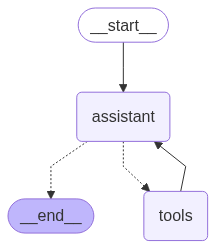

In [5]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": 2}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (414646b4-f03c-4203-992a-6c501d43eb66)
 Call ID: 414646b4-f03c-4203-992a-6c501d43eb66
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


In [7]:
# Get current state of our graph
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='78b8f185-0192-41f3-bd51-9a1addc58783'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--605f228a-7531-415c-95f3-268496072b50-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '414646b4-f03c-4203-992a-6c501d43eb66', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 66, 'total_tokens': 232, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 48}}), ToolMessage(content='6', name='multiply', id='0c04adee-85c0-4ccc-8c9a-c0813221d72c', tool_call_id='414646b4-f03c-4203-992a-6c501d43eb66'), AIMessage(content='The product of 2 and 3 is 6.', additional_kwargs=

In [8]:
# Get states history of our graph
state_history = [s for s in graph.get_state_history(thread)]
len(state_history)

5

In [9]:
state_history[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='78b8f185-0192-41f3-bd51-9a1addc58783')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f08d8e7-ba1c-6b36-8000-fb9c39f41890'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-09T15:05:54.755858+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f08d8e7-ba19-6166-bfff-f3add2823aa8'}}, tasks=(PregelTask(id='312ced63-0c44-bbc4-6ec8-5f21896c3ef0', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, i

We can rerun our agent from the previous states

In [10]:
to_replay = state_history[-3]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='78b8f185-0192-41f3-bd51-9a1addc58783'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--605f228a-7531-415c-95f3-268496072b50-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '414646b4-f03c-4203-992a-6c501d43eb66', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 66, 'total_tokens': 232, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 48}})]}, next=('tools',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f08d8e7-c2a7-6134-8001-a0d9ea246c12'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at

In [11]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='78b8f185-0192-41f3-bd51-9a1addc58783'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--605f228a-7531-415c-95f3-268496072b50-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '414646b4-f03c-4203-992a-6c501d43eb66', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 66, 'total_tokens': 232, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 48}})]}

In [12]:
to_replay.next

('tools',)

In [13]:
to_replay.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08d8e7-c2a7-6134-8001-a0d9ea246c12'}}

In [14]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (414646b4-f03c-4203-992a-6c501d43eb66)
 Call ID: 414646b4-f03c-4203-992a-6c501d43eb66
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


---
# Forking
When we want to run from the same step, but with a different input, we use Forking.

In [15]:
to_fork = state_history[-3]
to_fork.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='78b8f185-0192-41f3-bd51-9a1addc58783'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--605f228a-7531-415c-95f3-268496072b50-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '414646b4-f03c-4203-992a-6c501d43eb66', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 66, 'total_tokens': 232, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 48}})]}

In [16]:
to_fork.values['messages']

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='78b8f185-0192-41f3-bd51-9a1addc58783'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--605f228a-7531-415c-95f3-268496072b50-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '414646b4-f03c-4203-992a-6c501d43eb66', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 66, 'total_tokens': 232, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 48}})]

In [17]:
to_fork.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08d8e7-c2a7-6134-8001-a0d9ea246c12'}}

In [21]:
fork_config = graph.update_state(
    to_fork.config,
    {
        "messages": [HumanMessage(content="Multiply 5 and 3", id=to_fork.values["messages"][0].id)]
    }
)

In [23]:
state_history = [s for s in graph.get_state_history(thread)]
len(state_history)

8

In [27]:
graph.get_state(fork_config).values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='78b8f185-0192-41f3-bd51-9a1addc58783'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--605f228a-7531-415c-95f3-268496072b50-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '414646b4-f03c-4203-992a-6c501d43eb66', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 66, 'total_tokens': 232, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 48}})]

In [28]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (414646b4-f03c-4203-992a-6c501d43eb66)
 Call ID: 414646b4-f03c-4203-992a-6c501d43eb66
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

I'm sorry, I made a mistake and multiplied 2 and 3 instead of 5 and 3. My apologies. The product of 5 and 3 is 15.
